In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from src.features.feature_engineering_1 import *
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay

In [2]:
# Définition des années de train
years_train = ['2016', '2017', '2018', '2019']

In [3]:
# Chargement des données d'entrainement
data = get_all_season_data(years_train)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,x_coordinate,y_coordinate,empty_net,strength,last_event_type,last_event_x,last_event_y,time_since_last_event,distance_from_last_event
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,-77.0,5.0,NaN,NaN,Blocked Shot,-61.0,11.0,1,17.088007
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,86.0,13.0,NaN,NaN,Giveaway,54.0,-5.0,5,36.715120
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,23.0,-38.0,NaN,NaN,Missed Shot,-72.0,0.0,18,102.318131
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,33.0,-15.0,NaN,NaN,Missed Shot,77.0,-2.0,19,45.880279
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,-34.0,28.0,NaN,NaN,Hit,47.0,34.0,16,81.221918


In [4]:
# Ajout des features de distance et d'angle
data = add_new_features(data)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,...,strength,last_event_type,last_event_x,last_event_y,time_since_last_event,distance_from_last_event,distance_to_net,shot_angle,is_goal,is_empty_net
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,...,NaN,Blocked Shot,-61.0,11.0,1,17.088007,13.0,23.0,0,0
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,...,NaN,Giveaway,54.0,-5.0,5,36.715120,13.0,77.0,0,0
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,...,NaN,Missed Shot,-72.0,0.0,18,102.318131,76.0,30.0,0,0
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,...,NaN,Missed Shot,77.0,-2.0,19,45.880279,58.0,15.0,0,0
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,...,NaN,Hit,47.0,34.0,16,81.221918,62.0,27.0,0,0


In [5]:
# Sélection de la caractéristique distance_to_net et des labels is_goal
df1 = data[['distance_to_net', 'is_goal']]
df1.head()

,distance_to_net,is_goal
0,13.0,0
1,13.0,0
2,76.0,0
3,58.0,0
4,62.0,0


In [6]:
# Suppression des valeurs NaN
df1 = df1.dropna()

In [7]:
y1 = df1['is_goal'].values
X1 = df1['distance_to_net'].values

In [8]:
# Split des données d'entrainement en train et val
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2)

# Reshpae des array
X_train1 = X_train1.reshape(X_train1.shape[0], 1)
X_val1 = X_val1.reshape(X_val1.shape[0], 1)

**Question 1**

In [9]:
modele_base1 = LogisticRegression()
modele_base1.fit(X_train1, y_train1)

LogisticRegression()

In [10]:
# Prédiction des données de val
y_pred1 = modele_base1.predict(X_val1)

In [11]:
confusion_matrix(y_val1, y_pred1)

array([[59319,     0],
       [ 6146,     0]], dtype=int64)

In [12]:
print('Accuracy :', accuracy_score(y_val1, y_pred1))
print('Recall :', recall_score(y_val1, y_pred1))

Accuracy : 0.9061177728557245
Recall : 0.0


Nous remarquons que la précision du modèle est très bonne. Cependant ce résultat est trompeur car le modèle prédit que tous les exemples de l'ensemble de validation sont de la classe 0 (à l'aide de la matrice de confusion)

En calculant le Recall on se rend compte qu'il vaut 0. C'est un très très mauvais résultat.

Les problèmes possibles sont :
- Pas assez d'exemple de la classe 1 (pour un but)
- Seul la distance ne suffit pas pour prédire correctement 

**Question 2**

In [13]:
def plot_roc_curve(y_val, y_pred_proba):
    #https://www.statology.org/plot-roc-curve-python/
    #define metrics
    #y_pred_proba = model.predict_proba(X_val)
    
    fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
    auc = roc_auc_score(y_val,  y_pred_proba)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='red', linestyle='--', label='AUC=0.5')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Courbe ROC')
    plt.grid()
    plt.legend(loc=4)

In [14]:
def plot_goal_rate(y_val, y_pred_proba):

    #y_pred_proba = model.predict_proba(X_val)
    proba_but = y_pred_proba
    
    percentiles = np.linspace(0, 100, 10)
    percentile_but = np.percentile(proba_but, np.linspace(0, 100, 11))
    taux_buts = []

    for i in range(len(percentiles)):

        percentile_inf = percentile_but[i]
        percentile_sup = percentile_but[i + 1]
        
        indices = np.where((proba_but >= percentile_inf) & (proba_but <= percentile_sup))
        
        goals_in_percentile = np.sum(y_val[indices])
        total_shots_percentile = y_val[indices].shape[0]
        taux_buts.append((goals_in_percentile / total_shots_percentile) * 100)

    
    plt.plot(np.linspace(0, 100, 10), taux_buts)
    plt.ylim(0, 100)
    plt.xlim(110, -10)
    plt.xlabel('Shot Probability model percentile')
    plt.ylabel('Goals / (Goals + Shots)')
    plt.title('Goal Rate')
    plt.grid()

In [15]:
def plot_cumulative_percent_goal(y_val, y_pred_proba):
    proba_but = y_pred_proba
    
    percentiles = np.linspace(0, 100, 10)
    percentile_but = np.percentile(proba_but, np.linspace(0, 100, 10))
    proportions_buts = []

    for i in range(len(percentiles)):

        percentile_i = percentile_but[i]
        
        indices = np.where(proba_but <= percentile_i)
        
        goals_in_percentile = np.sum(y_val[indices])
        
        total_shots_percentile = np.sum(y_val)

        proportions_buts.append((goals_in_percentile / total_shots_percentile) * 100)

    plt.plot(np.linspace(100, 0, 10), proportions_buts)
    plt.ylim(0, 110)
    plt.xlim(110, -10)
    plt.xlabel('Shot Probability model percentile')
    plt.ylabel('Proportion')
    plt.title('Cumulative % of goals')
    plt.grid()

In [16]:
def plot_fiability_diagram(y_val, y_pred_proba):

    #y_pred_proba = model.predict_proba(X_val)
    proba_but = y_pred_proba

    ax = plt.subplot(2, 2, 4)
    ax.set_title('Diagramme de fiabilité')

    CalibrationDisplay.from_predictions(y_val, proba_but, ax=ax)

In [17]:
def plot_metrics(y_val, y_pred_proba):
    
    # Créez une nouvelle figure avec une grille 2x2 d
    plt.figure(figsize=(12, 8))

    # Créez chaque sous-tracé individuellement
    plt.subplot(2, 2, 1)
    plot_roc_curve(y_val, y_pred_proba)

    plt.subplot(2, 2, 2)
    plot_goal_rate(y_val, y_pred_proba)

    plt.subplot(2, 2, 3)
    plot_cumulative_percent_goal(y_val, y_pred_proba)

    #plt.subplot(2, 2, 4)
    plot_fiability_diagram(y_val, y_pred_proba)

    # Ajustez l'espacement entre les sous-tracés pour éviter le chevauchement
    plt.tight_layout()

    # Affichez la figure
    plt.show()

**2**

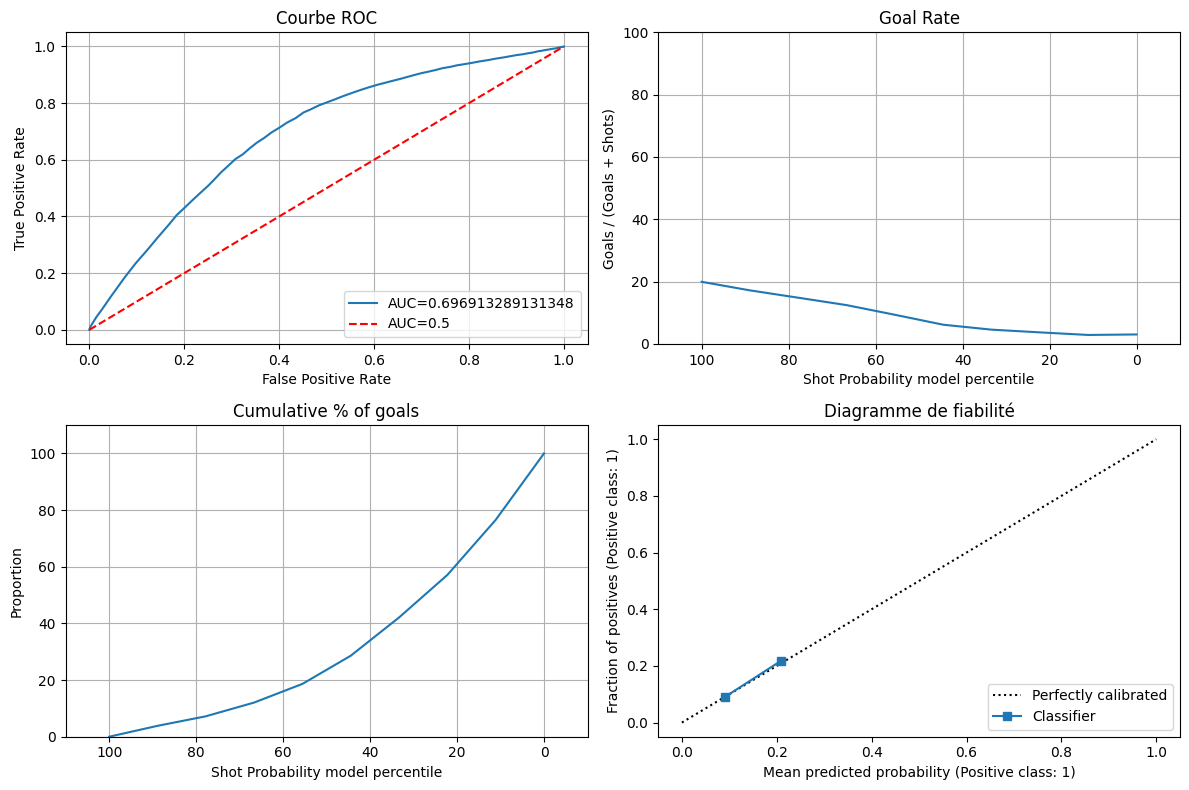

In [18]:
y_pred_proba1 = modele_base1.predict_proba(X_val1)[:, 1]
plot_metrics(y_val1, y_pred_proba1)

**Question 3**

Utilisation de la caractéristique d'angle uniquement

In [19]:
#utilisation de la caractéristique d'angle
df2 = data[['shot_angle', 'is_goal']]
df2 = df2.dropna()
df2.head()

,shot_angle,is_goal
0,23.0,0
1,77.0,0
2,30.0,0
3,15.0,0
4,27.0,0


In [20]:
y2 = df2['is_goal'].values
X2 = df2['shot_angle'].values

# Split des données d'entrainement en train et val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2)

# Reshpae des array
X_train2 = X_train2.reshape(X_train2.shape[0], 1)
X_val2 = X_val2.reshape(X_val2.shape[0], 1)

In [21]:
modele_base2 = LogisticRegression()
modele_base2.fit(X_train2, y_train2)

LogisticRegression()

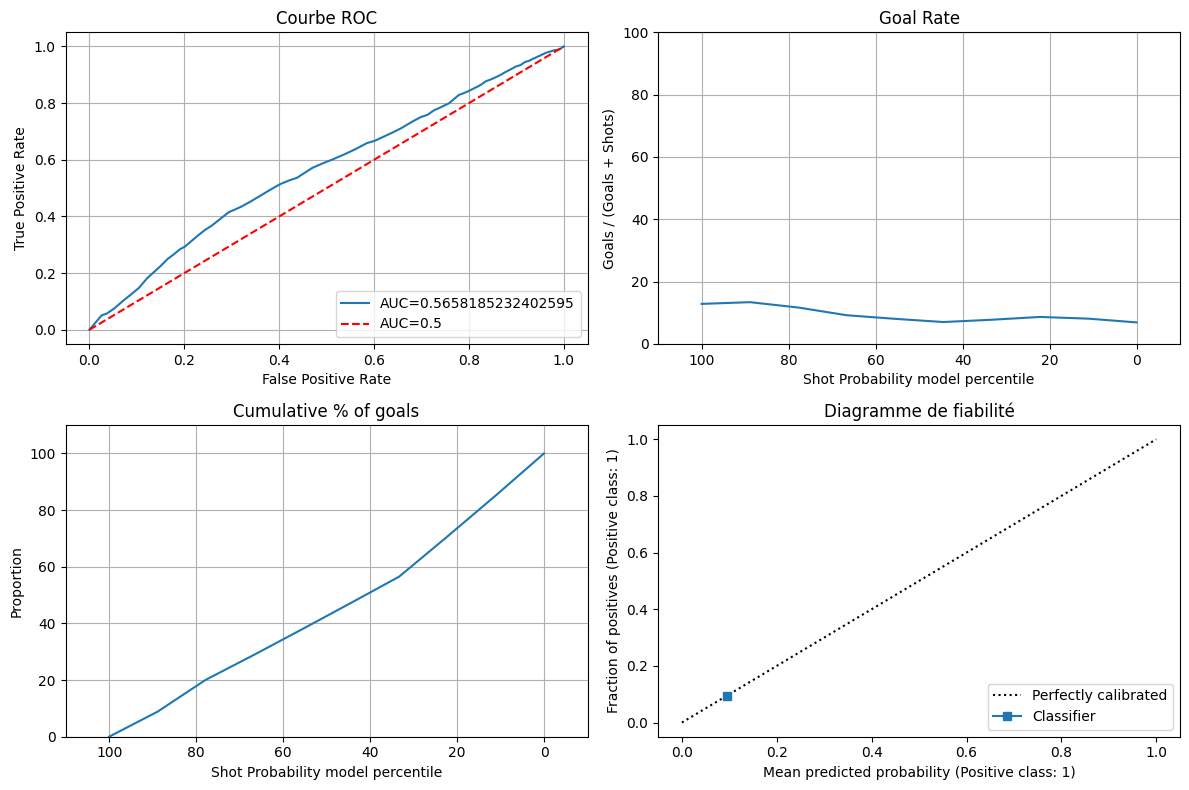

In [22]:
y_pred_proba2 = modele_base2.predict_proba(X_val2)[:, 1]
plot_metrics(y_val2, y_pred_proba2)

Utilisation de la caractéristique d'angle et distance

In [23]:
#utilisation de la caractéristique d'angle
df3 = data[['distance_to_net', 'shot_angle', 'is_goal']]
df3 = df3.dropna()
df3.head()

,distance_to_net,shot_angle,is_goal
0,13.0,23.0,0
1,13.0,77.0,0
2,76.0,30.0,0
3,58.0,15.0,0
4,62.0,27.0,0


In [24]:
y3 = df3['is_goal'].values
X3 = df3[['distance_to_net', 'shot_angle']].values

# Split des données d'entrainement en train et val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y3, test_size=0.2)

In [25]:
modele_base3 = LogisticRegression()
modele_base3.fit(X_train3, y_train3)

LogisticRegression()

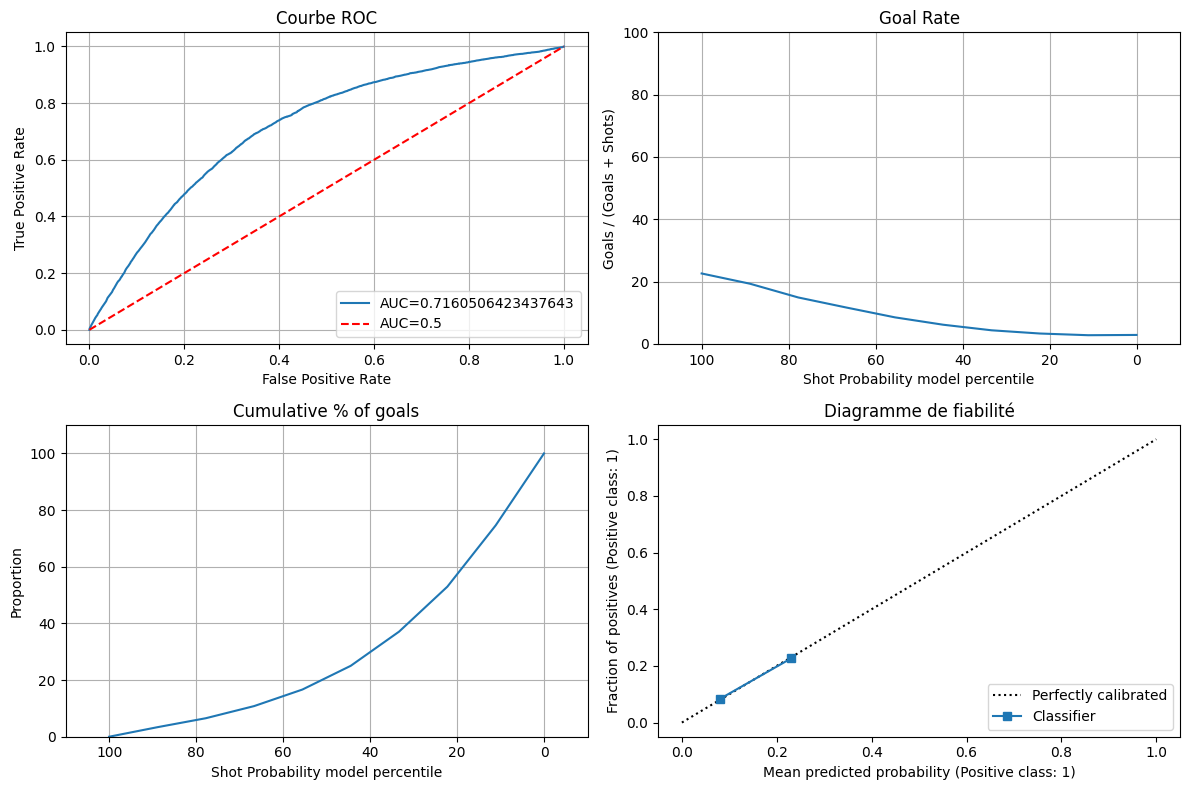

In [26]:
y_pred_proba3 = modele_base3.predict_proba(X_val3)[:, 1]
plot_metrics(y_val3, y_pred_proba3)

$\textbf{Ligne de base aléatoire}$

In [35]:
random_proba = np.random.uniform(0, 1, len(y_val3))

In [36]:
y_pred_proba4 = (random_proba > 0.5) * 1
print(accuracy_score(y_val3, y_pred_proba4))

0.5055831360268846


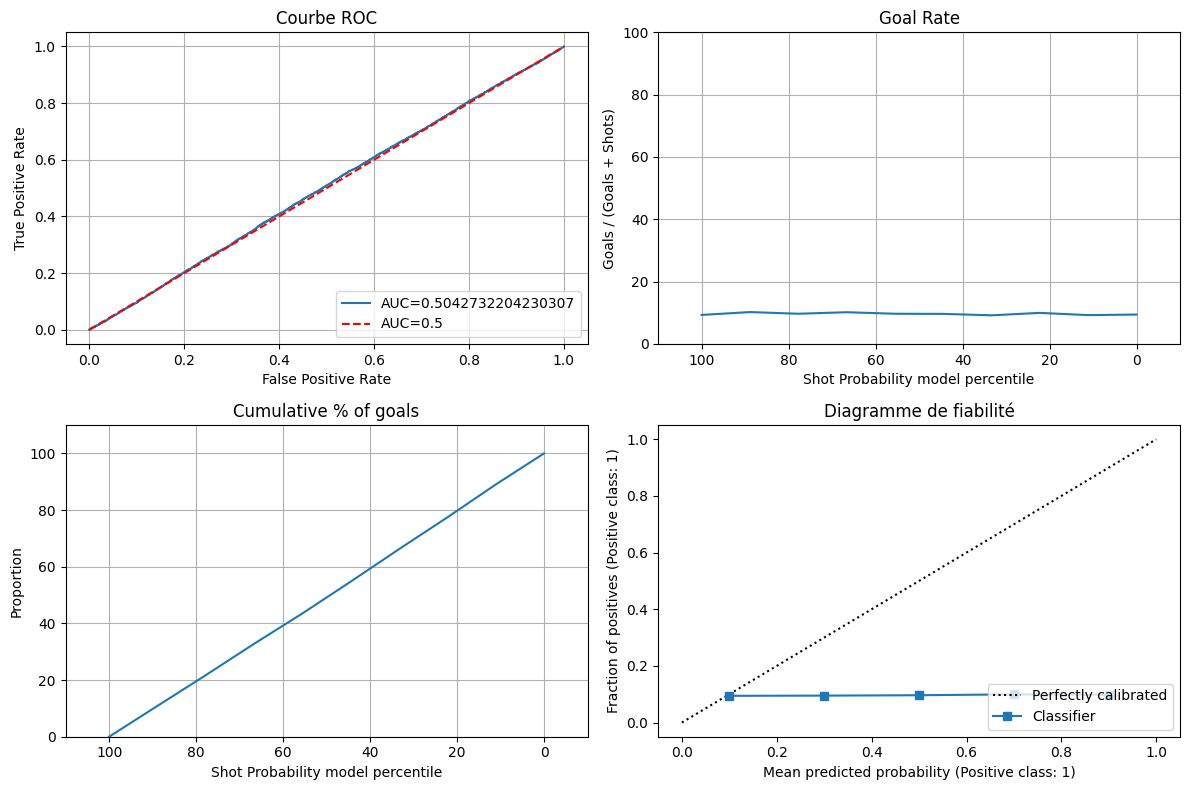

In [37]:
plot_metrics(y_val3, random_proba)